In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [65]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
import featuretools as ft
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.utils import resample
from sklearn.ensemble import BaggingClassifier
import random

In [31]:
# load data
dataframe_org = pd.read_csv('train.csv', delimiter='|')
dataframe = dataframe_org.copy()

########### manual feature generation ##########

# totalScanned:
dataframe['totalScanned'] = dataframe['scannedLineItemsPerSecond'] * dataframe['totalScanTimeInSeconds']
# avgValuePerScan:
dataframe['avgTimePerScan'] = 1/ dataframe['scannedLineItemsPerSecond']
dataframe['avgValuePerScan'] = dataframe['avgTimePerScan'] * dataframe['valuePerSecond']
# manual feature generation - "totalScanned" ratios
# withoutRegisPerPosition
dataframe['withoutRegisPerPosition'] = dataframe['scansWithoutRegistration'] / dataframe['totalScanned']
# ratio of scansWithoutRegis in totalScan
# equivalent to lineItemVoidsPerPosition
# Might indicate how new or ambivalent a customer is. Expected to be higher for low "trustLevel"
# quantiModPerPosition
dataframe['quantiModPerPosition'] = dataframe['quantityModifications'] / dataframe['totalScanned']
# ratio of quanityMods in totalScan
# manual feature generation - "grandTotal" ratios
# lineItemVoidsPerTotal
dataframe['lineItemVoidsPerTotal'] = dataframe['lineItemVoids'] / dataframe['grandTotal']
# withoutRegisPerTotal
dataframe['withoutRegisPerTotal'] = dataframe['scansWithoutRegistration'] / dataframe['grandTotal']
# quantiModPerTotal
dataframe['quantiModPerTotal'] = dataframe['quantityModifications'] / dataframe['grandTotal']
# manual feature generation - "totalScanTimeInSeconds" ratios
# lineItemVoidsPerTime
dataframe['lineItemVoidsPerTime'] = dataframe['lineItemVoids'] / dataframe['totalScanTimeInSeconds']
# withoutRegisPerTime
dataframe['withoutRegisPerTime'] = dataframe['scansWithoutRegistration'] / dataframe['totalScanTimeInSeconds']
# quantiModPerTime
dataframe['quantiModPerTime'] = dataframe['quantityModifications'] / dataframe['totalScanTimeInSeconds']

########### end manual feature generation ###########

In [4]:
cv = StratifiedKFold(n_splits=10, random_state=42)
def profit_scorer(y, y_pred):
    profit_matrix = {(0,0): 0, (0,1): -5, (1,0): -25, (1,1): 5}
    return sum(profit_matrix[(pred, actual)] for pred, actual in zip(y_pred, y))
profit_scoring = make_scorer(profit_scorer, greater_is_better=True)

In [44]:
len(dataframe)

1879

In [93]:
pd.set_option('display.max_columns', 500)

In [53]:
result_c1=[]
result_c2=[]

for j in range (30):    
    bootstrap = resample(dataframe, replace=True, n_samples=1879, random_state=j)
    #outofbag = [x for x in dataframe if x not in bootstrap]
    print('random seed= ', j)

    X = bootstrap.drop('fraud',axis=1)
    y = bootstrap['fraud']
    es = ft.EntitySet(id = 'customers')
    es = es.entity_from_dataframe(entity_id='customers',dataframe=X,
                                  variable_types = {'trustLevel': ft.variable_types.Categorical},index='id',make_index=True)


    # Testing PCA, automatic feature generation w/ featuretools (previously manual generated features incorporated), 
    # and SelectKBest
    # create feature union
    features = []
    features.append(('pca', PCA(n_components=3)))
    features.append(('ft', ft.wrappers.DFSTransformer(entityset = es, target_entity = 'customers')))
    features.append(('select_best', SelectKBest(k=4)))
    feature_union = FeatureUnion(features)

    # create pipeline for c=1
    estimators = []
    estimators.append(('feature_union', feature_union))
    estimators.append(('LR', LogisticRegression(penalty='l2',C=1)))
    lr_af = Pipeline(estimators)
    result = sum(cross_validate(lr_af, X, y=y, cv=cv, scoring=profit_scoring)['test_score'])
    result_c1.append(result)
    
    print('C=1')
    print('LR w/ PCA & featuretools (no primitives selected) & SelectKBest on data w/ additional manual features generated: {}'
          .format(result))
    
    
    # create pipeline for c=2
    estimators = []
    estimators.append(('feature_union', feature_union))
    estimators.append(('LR', LogisticRegression(penalty='l2',C=2)))
    lr_af = Pipeline(estimators)
    result = sum(cross_validate(lr_af, X, y=y, cv=cv, scoring=profit_scoring)['test_score'])
    result_c2.append(result)

    print('C=2')
    print('LR w/ PCA & featuretools (no primitives selected) & SelectKBest on data w/ additional manual features generated: {}'
          .format(result))




random seed=  0
C=1
LR w/ PCA & featuretools (no primitives selected) & SelectKBest on data w/ additional manual features generated: 450
C=2
LR w/ PCA & featuretools (no primitives selected) & SelectKBest on data w/ additional manual features generated: 425
random seed=  1
C=1
LR w/ PCA & featuretools (no primitives selected) & SelectKBest on data w/ additional manual features generated: 275
C=2
LR w/ PCA & featuretools (no primitives selected) & SelectKBest on data w/ additional manual features generated: 285
random seed=  2
C=1
LR w/ PCA & featuretools (no primitives selected) & SelectKBest on data w/ additional manual features generated: 445
C=2
LR w/ PCA & featuretools (no primitives selected) & SelectKBest on data w/ additional manual features generated: 435
random seed=  3
C=1
LR w/ PCA & featuretools (no primitives selected) & SelectKBest on data w/ additional manual features generated: 310
C=2
LR w/ PCA & featuretools (no primitives selected) & SelectKBest on data w/ additional

(array([3., 1., 3., 3., 9., 3., 3., 2., 1., 2.]),
 array([160. , 189.5, 219. , 248.5, 278. , 307.5, 337. , 366.5, 396. ,
        425.5, 455. ]),
 <a list of 10 Patch objects>)

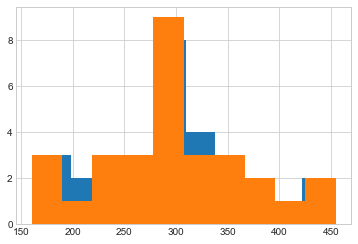

In [54]:
plt.hist(result_c1)
plt.hist(result_c2)

In [ ]:
penalty='l1' seem to preform worse than l2

In [61]:
bootstrap = resample(dataframe, replace=True, n_samples=1879, random_state=j)
outofbag = [x for x in dataframe if x not in bootstrap]
outofbag


[]

In [103]:
def OOB_sample(data, no_resamples, return_leftovers=False):
    data_rows=list(data.index)
    random_rows=[random.choice(data_rows) for row in range(no_resamples)]
    if not return_leftovers:
        return data.ix[random_rows]
    leftover_rows=filter(lambda x: not x in random_rows, data_rows)
    return[data.ix[random_rows], data.ix[leftover_rows]]

resample = OOB_sample(dataframe, 1879, True)

bootstrap_train =resample[0]
bootstrap_test =resample[1]

bootstrap_train_X = bootstrap_train.drop(['fraud'], axis=1)
bootstrap_train_y = bootstrap_train['fraud']

bootstrap_test_X = bootstrap_test.drop(['fraud'], axis=1)
bootstrap_test_y = bootstrap_test['fraud']

# X = dataframe.drop('fraud',axis=1)
# y = dataframe['fraud']

es = ft.EntitySet(id = 'customers')
es = es.entity_from_dataframe(entity_id='customers',dataframe=bootstrap_train_X,
                              variable_types = {'trustLevel': ft.variable_types.Categorical},index='id',make_index=True)

bootstrap_train_X = bootstrap_train_X.drop(['id'], axis=1)

print(len(bootstrap_train),
      len(bootstrap_test),
      len(bootstrap_train_X),
      len(bootstrap_train_y),
      len(bootstrap_test_X),
      len(bootstrap_test_y))

print(#len(bootstrap_train),
      #len(bootstrap_test),
      len(bootstrap_train_X.columns),
      #len(bootstrap_train_y),
      len(bootstrap_test_X.columns))
      #len(bootstrap_test_y))

bootstrap_train_X

1879 684 1879 1879 684 684
20 20


,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,totalScanned,avgTimePerScan,avgValuePerScan,withoutRegisPerPosition,quantiModPerPosition,lineItemVoidsPerTotal,withoutRegisPerTotal,quantiModPerTotal,lineItemVoidsPerTime,withoutRegisPerTime,quantiModPerTime
380,5,1621,53.69,0,7,1,0.016039,0.033122,0.000000,26.0,62.346154,2.065000,0.269231,0.038462,0.000000,0.130378,0.018625,0.000000,0.004318,0.000617
1370,2,1793,6.71,5,7,0,0.015059,0.003742,0.185185,27.0,66.407407,0.248519,0.259259,0.000000,0.745156,1.043219,0.000000,0.002789,0.003904,0.000000
119,6,493,86.24,6,0,3,0.036511,0.174929,0.333333,18.0,27.388889,4.791111,0.000000,0.166667,0.069573,0.000000,0.034787,0.012170,0.000000,0.006085
1120,6,378,2.36,9,5,2,0.052910,0.006243,0.450000,20.0,18.900000,0.118000,0.250000,0.100000,3.813559,2.118644,0.847458,0.023810,0.013228,0.005291
15,1,870,32.45,3,1,5,0.006897,0.037299,0.500000,6.0,145.000000,5.408333,0.166667,0.833333,0.092450,0.030817,0.154083,0.003448,0.001149,0.005747
1875,1,397,41.89,5,5,0,0.065491,0.105516,0.192308,26.0,15.269231,1.611154,0.192308,0.000000,0.119360,0.119360,0.000000,0.012594,0.012594,0.000000
584,2,502,23.46,6,3,4,0.057769,0.046733,0.206897,29.0,17.310345,0.808966,0.103448,0.137931,0.255754,0.127877,0.170503,0.011952,0.005976,0.007968
1699,3,141,84.92,5,0,3,0.078014,0.602270,0.454545,11.0,12.818182,7.720000,0.000000,0.272727,0.058879,0.000000,0.035327,0.035461,0.000000,0.021277
1251,1,1246,62.61,1,9,4,0.014446,0.050249,0.055556,18.0,69.222222,3.478333,0.500000,0.222222,0.015972,0.143747,0.063888,0.000803,0.007223,0.003210
1334,2,932,34.86,1,8,4,0.004292,0.037403,0.250000,4.0,233.000000,8.715000,2.000000,1.000000,0.028686,0.229489,0.114745,0.001073,0.008584,0.004292


In [104]:

# Testing PCA, automatic feature generation w/ featuretools (previously manual generated features incorporated), 
# and SelectKBest
# create feature union
features = []
features.append(('pca', PCA(n_components=3)))
features.append(('ft', ft.wrappers.DFSTransformer(entityset = es, target_entity = 'customers')))
features.append(('select_best', SelectKBest(k=4)))
feature_union = FeatureUnion(features)

# create pipeline for c=1
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('LR', LogisticRegression(penalty='l2',C=1)))
lr_af = Pipeline(estimators)

lr_af.fit(bootstrap_train_X, bootstrap_train_y)
prediction = lr_af.predict(bootstrap_test_X)
lr_af.score(bootstrap_test_X, bootstrap_test_y)

# print('C=1')
# print('LR w/ PCA & featuretools (no primitives selected) & SelectKBest on data w/ additional manual features generated: {}'
#       .format(result))


# # create pipeline for c=2
# estimators = []
# estimators.append(('feature_union', feature_union))
# estimators.append(('LR', LogisticRegression(penalty='l2',C=2)))
# lr_af = Pipeline(estimators)
# result = sum(cross_validate(lr_af, X, y=y, cv=cv, scoring=profit_scoring)['test_score'])
# result_c2.append(result)

# print('C=2')
# print('LR w/ PCA & featuretools (no primitives selected) & SelectKBest on data w/ additional manual features generated: {}'
#       .format(result))




AttributeError: Name of the index variable in the target entity or "instance_id" must be present in cutoff_time